**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1l9jgkXm-RcvY3SE94cZiP_PYxegAoPDa?usp=sharing)
2. Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1xJnAZG5CY1sZftGGG5Qq5Ze-ZveYHcRH?usp=sharing)


## Загрузка библиотек

In [ ]:
import struct
import gdown

# библиотека numpy
import numpy as np

# Слои нейронной сети
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# работа со слоями
from tensorflow.keras.layers import add, concatenate

# создание моделей
from tensorflow.keras.models import Model

# загрузчик сохраненных моделей
from tensorflow.keras.models import load_model

# итератор, повторно возвращающий указанный объект 
from itertools import repeat

# регуляризатор, который применяет штраф за регуляризацию L2
from tensorflow.keras.regularizers import l2 

# модуль для отрисовки изображения
from tensorflow.keras.preprocessing import image 

# Функция для отрисовки структуры модели
from tensorflow.keras.utils import plot_model 

# Импортируем tensorflow
import tensorflow as tf 

# gрямоугольник, определяемый точкой привязки xy , а также его шириной и высотой
from matplotlib.patches import Rectangle

# возвращение списка (возможно, пустого) путей, соответствующих шаблону pathname
from glob import glob

# библиотека для работы с файлами
import os

import gdown

# визуализация 
from matplotlib import pyplot as plt
%matplotlib inline  

## Создаем YOLOv3
<p> В этом блоке собраны все функции разобранные в теории, модель YOLO также обёрнута в виде функции `create_yolov3_model()`:


### Функции из лекции

In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True, layer_idx=None): # DarknetConv2D_BN_Leaky
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        kernel - размер ядра свертки, целое число
        stride - шаг свертки, целое число
        batch_norm - включать или ветку со слоем Batchnormalization и активационной функцией LeakyReLu. 
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx+1 -номер следующего слоя

    '''
    
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005), name='conv_' + str(layer_idx))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(layer_idx))(x)
        x = LeakyReLU(alpha=0.1,name='leake_' + str(layer_idx))(x)
    
    return x, layer_idx+1

In [ ]:
def Res_unit(x, filters, layer_idx): # DarknetResidual

    '''
    Функция определяет минимальную ячейку Residual блока
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx+1 - номер следующего слоя

    '''

    skip_connection = x
    x, layer_idx = DBL(x, filters // 2, kernel=1, layer_idx=layer_idx)
    x, layer_idx = DBL(x, filters, kernel=3, layer_idx=layer_idx)
    x = add([skip_connection , x], name='Add_'+str(layer_idx))

    return x, layer_idx+1

In [ ]:
def ResBlock(x, filters, blocks, layer_idx): # DarknetBlock

    '''
    Функция определяет Residual блок состоящий из входного сверточного слоя 
    и последовательности Res_unit блоков
    
    Args:
        x - тензор входных данных
        filters - задает количество фильтров
        block - задает количество Residual 'ячеек', а именно, сколько раз повторить в цикле функцию Res_unit
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx -номер слоя

    '''

    x, layer_idx = DBL(x, filters, kernel=3, strides=2, layer_idx=layer_idx)
    
    for _ in repeat(None, blocks):
        x, layer_idx = Res_unit(x, filters, layer_idx=layer_idx)
    
    return x, layer_idx

In [ ]:
def Detector(x_in, filters, layer_idx=None):
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x_in - тензор или список тензоров
        filters - количество фильтров
        layer_idx - номер следующего сверточного слоя
    
    Return:
        bboxes - рамки
        fork - тензор
        layer_idx -номер слоя

    '''

    if isinstance(x_in, list): # Если на вход поступает список попадаем в эту ветку (маршруты 2 и 3)
        x, x_skip = x_in[0], x_in[1]# Разбиваем список на отдельные тензоры
        x,layer_idx = DBL(x, filters, kernel=1, strides=1, layer_idx=layer_idx) # DarknetConv
        x = UpSampling2D(2, name = 'UpSampling_' + str(layer_idx))(x) # Повышаем размерность тензора
        layer_idx+=1
        x =concatenate([x, x_skip], name = 'Concatenate_' + str(layer_idx)) # Объединяем маршруты
        layer_idx+=1
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб         
    
    else: # В эту ветку попадает только маршрут 1
        x = x_in
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб 

    # Предпоследний сверточный слой (№80 13х13х1024, #92 26x26x512, #104 52x52x256)
    x,layer_idx = DBL(fork, filters=filters*2, kernel=3, strides=1, layer_idx=layer_idx)

    # Выходные слои (№81 13х13х (anchors * (4 + 1 + classes)), №93 26х26, №105 52х52 (255) 
    bboxes, layer_idx = DBL(x, filters=num_sub_anchors * (4 + 1 + num_classes), kernel=1, strides=1, batch_norm= False, layer_idx=layer_idx)       

    return bboxes, fork, layer_idx

### Создание create_yolov3_model

In [ ]:
def create_yolov3_model(inputs, num_sub_anchors, num_classes):
    
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        inputs - входной тензор  
        num_sub_anchors - количество анкоров 
        num_classes - количество классов
    
    Return:
        model - модель

    '''
    layer_idx = 0 # Номер первого слоя
    x, layer_idx = DBL(inputs, filters=32, kernel=3, layer_idx=layer_idx)       # DarknetConv 1 слой
    x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)            # DarknetBlock 3 слоя
    x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)           # DarknetBlock 5 слоя
    x, layer_idx = Route_1,_ = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    x, layer_idx = Route_2,_ = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    Route_3, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)          # последние 4 Res блока Darknet
    
    # 5 сверточных слоев DBL
    bbox_scale_1, fork_1, layer_idx = Detector(Route_3, filters=512, layer_idx=layer_idx) 

    # 82 слой на первый выход  83 пропуск
    layer_idx = 84
    bbox_scale_2, fork_2, layer_idx = Detector([fork_1, Route_2], filters=256, layer_idx=layer_idx) # 6 слоев
 
    # слои 94-95 пропущены
    layer_idx = 96
    bbox_scale_3, _, layer_idx = Detector([fork_2, Route_1], filters=128, layer_idx=layer_idx) # 6 слоев

    model = Model (inputs, [bbox_scale_1, bbox_scale_2, bbox_scale_3])

    return model

Проверим на практике работу функции:

In [ ]:
size = 416

channels= 3
num_sub_anchors=3
num_classes=80
inputs = Input([size, size, channels])

# создаем модель
model = create_yolov3_model(inputs, num_sub_anchors, num_classes)

# выводим сводку
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, 416, 416, 32  128         ['conv_0[0][0]']                 
                                )                                                             

## Веса нейросетей

Файлы весов нейросети - это двоичные файлы, которые содержат значения (веса), хранящиеся в последовательном порядке.

При загрузке весов следует соблюдать определённые процедуры, так как веса просто хранятся как числа с плавающей запятой, и ничто не указывает нам, к какому слою они принадлежат. Если вы ошиблись, ничего не мешает, скажем, загрузить веса слоя нормализации (Batchnormalization) в сверточный слой (Conv).
<p>Поскольку числа с плавающей запятой различить невозможно и невозможно понять какое число пренадлежит какому слою, мы должны понять, как хранятся веса.

Веса принадлежат только двум типам слоев, `Batchnormalization` и `Conv2D` 

**Обратите внимание!**  Сейчас речь идет  ТОЛЬКО  о весах для нашей сети  YOLOv3  других слоев, которые могут иметь веса в ней просто нет.

Веса для этих слоев хранятся точно в том же порядке, в каком они идут в структуре сети. Итак, если за `Conv` блоком следует `Shortcut`-соединение (прямое соединение), а за `Shortcut` соединением следует другой `Conv` блок, мы ожидаем, что файл будет содержать веса предыдущего `Conv` блока, за которым следуют веса следующего. 

Однако когда в `Conv` блоке есть слой `Batchnormalization`, там нет смещения  (biases). И наоборот, если слоя `Batchnormalization` нет, веса смещения `bias weights` должны считываться из файла.


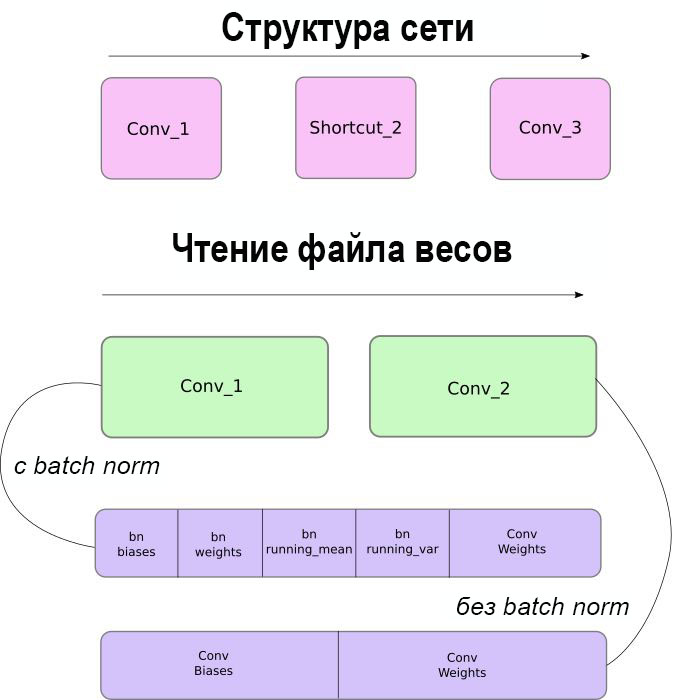

Рисунок 1. Cхема считывания весов из файла

Итак, для загрузки весов предоставленных разработчиком, нам потребуется специальный класс `WeightReader`. Кроме self он принимает на вход один аргумент - `weight_file`, путь с именем к файлу весов.

В нем хранятся:
- Номер основной версии ( Major version number )
- Номер дополнительной версии (Minor version number)
- Номер подверсии (Subversion number)
- Изображения, увиденные сетью во время обучения



Итак, экземпляр `WeightReader`считывает заголовок файла. Остальные биты представляют веса в порядке следования слоев в модели. Веса хранятся как float32 или 32-битные числа с плавающей запятой. Они загружаются в numpy массив `self.all_weights`.

Остальные биты представляют веса в порядке, следования слоев в моделе. Веса хранятся как float32 или 32-битные числа с плавающей запятой. Они загружаются в numpy массив `self.all_weights`

In [ ]:
def __init__(self, weight_file):
    
    ''' Функция декодирования выхода сети 
        
        Args:
            weight_file - файл с весами модели
        
        Return:
            -
        '''

    with open(weight_file, 'rb') as w_f:
        major,	= struct.unpack('i', w_f.read(4))
        minor,	= struct.unpack('i', w_f.read(4))
        revision, = struct.unpack('i', w_f.read(4))
        
        if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
            w_f.read(8)
        else:
            w_f.read(4)
        transpose = (major > 1000) or (minor > 1000)
        binary = w_f.read()
    
    self.offset = 0
    
    self.all_weights = np.frombuffer(binary, dtype='float32')

Для позиционирования в массиве используется функция `read_bytes`. Она принимает в качестве аргумента размер текущего блока, который прочитан в данный момент и прибавляет это значение к переменной `self.offset` (смещение). Изначально значение переменной равно 0. Так последовательно блок за блоком считываются байты из файла весов.

In [ ]:
def read_bytes(self, size):

    '''
    Функция позиционирования
    
    Args:
        self
        size - размер текущего блока
    
    Return:
        размер блока, суммированный со смещением

    '''
    self.offset = self.offset + size

    return self.all_weights[self.offset-size:self.offset]

Функция  `load_weights` принимает в качестве аргумента модель сети `model`, проходит последовательно в цикле по слоям модели (всего 106) и загружает в них соответствующие веса.

Именно для этого при создании модели осуществляется сквозная нумерация ее слоев. Если создать модель без присвоения слоям порядковых номеров, данная функция не сработает.

In [ ]:
def load_weights(self, model):

    '''
    Функция загрузки весов
    
    Args:
        self
        model - модель
    
    Return:
        -

    '''    
    for i in range(106):
        try:
            conv_layer = model.get_layer('conv_' + str(i))
            print("loading weights of convolution #" + str(i))
            
            if i not in [81, 93, 105]:
                norm_layer = model.get_layer('bnorm_' + str(i))
                size = np.prod(norm_layer.get_weights()[0].shape)
                beta  = self.read_bytes(size) # bias
                gamma = self.read_bytes(size) # scale
                mean  = self.read_bytes(size) # mean
                var   = self.read_bytes(size) # variance
                weights = norm_layer.set_weights([gamma, beta, mean, var])
            
            if len(conv_layer.get_weights()) > 1:
                bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                kernel = kernel.transpose([2,3,1,0])
                conv_layer.set_weights([kernel, bias])
            
            else:
                kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                kernel = kernel.transpose([2,3,1,0])
                conv_layer.set_weights([kernel])
        
        except ValueError:
            print("no convolution #" + str(i))

### Вспомогательные функции загрузки весов

Ниже представлен класс `WeightReader` который позволяет сконвертировать и установить веса предобученной модели по слоям.



In [ ]:
class WeightReader:
    
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0


<p>Чтобы использовать `WeightReader`, ему создается экземпляр с путем к нашему файлу весов. Он проанализирует файл и загрузит веса модели в загрузчик.

In [ ]:
# Загружаем веса модели в конвертер весов

weight_reader = WeightReader(gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/yolov3.weights', None, quiet=True))

### Загузка весов

Затем мы можем вызвать функцию load_weights () экземпляра WeightReader, передав нашу определенную модель Keras, чтобы установить веса в слоях.


In [ ]:
# Устанавливаем веса в слои модели 

weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

Вот и все; Теперь у нас есть модель YOLOv3 для использования.
Мы можем сохранить модель в формате .h5, что бы загружать веса в модель привычным для нас способом (без конвертера)

In [ ]:
# сохраняем модель в файл, запишите ваш путь

model.save('/content/drive/yolov3.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Функции визуализации
Класс <b>BoundBox</b> и функции ниже, используются для отображения рамок (bounding box) на обнаруженных объектах в исходном изображении.

In [ ]:
class BoundBox:

    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
    
    def get_label(self):
        
        ''' # Функция для получения значения метки'''
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label
   
    def get_score(self):
        
        ''' Функция получения вероятности текущей метки'''        
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

In [ ]:
def _sigmoid(x):    
    
    ''' Функция расчета сигмоиды из аргумента '''

    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    
    ''' Функция декодирования выхода сети 
        Args:
            netout - 
            anchors - 
            obj_thresh - 
            net_h - 
            net_w -
        
        Return:
            boxes -
        '''
        
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 5-й элемент объектность (4-й если считать с нуля). Поулчаем вероятность нахождения объекта
            objectness = netout[int(row)][int(col)][b][4]
            
            if(objectness.all() <= obj_thresh): continue
            # первые 4 элемента - это x, y, w и h 
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # центральное подожение рамки относительно ширины сетки (якорного поля)
            y = (row + y) / grid_h # центральное подожение рамки относительно высоты сетки (якорного поля)
            w = anchors[2 * b + 0] * np.exp(w) / net_w # ширина рамки bbox 
            h = anchors[2 * b + 1] * np.exp(h) / net_h # высота рамки bbox
           
            # последине элементы - вероятности классов текущего объекта
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    
    return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    
    ''' Функция ???
        
        Args:
            boxes -
            image_h -
            image_w -
            net_h -
            net_w -
        
        Return:
            -
        '''    
    new_w, new_h = net_w, net_h
    
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
    

    ''' Функция рассчитывает интервал между углами рамок в зависимости от их взаимного расположения.
        Args:
            interval_a - координаты углов двух рамок по оси X.
            interval_b - координаты углов двух рамок по оси Y.
        Return:
            значение интервала между крайними точками.
    ''' 
    
    x1, x2 = interval_a
    x3, x4 = interval_b
    
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

In [ ]:
def intersectionOverUnion(box1, box2):
    
    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение IoU.
    '''

    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    
    return float(intersect_area) / union_area

In [ ]:
def do_nms(boxes, nms_thresh): 
    
    ''' 
    Функция  подавления лишних BBox Non Maximum Suppression
    
    Args:
        boxes - рамки 
        nms_thresh - пороговое значение
    Return: -

    '''
    
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                
                if intersectionOverUnion(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
def get_boxes(boxes, labels, thresh):
    
    ''' Функция получения результатов выше заданного порогового значения

        Args:
            boxes - рамки
            labels - их лейблы
            thresh - пороговое значение

        Return:
            v_boxes - рамки, подходящие под условия
            v_labels - их классы
            v_scores - значение вероятности
        '''      
    
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    # проходим в цикле по каждой рамке    
    for box in boxes:
        # проходим в цикле по каждой вероятной метке класса
        
        for i in range(len(labels)):
            # проверяем превышает ли вероятность метки класса пороговое значение threshold
            
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # для одной рамки может быть назначено несколько классов
    
    return v_boxes, v_labels, v_scores

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    
    ''' Функция отрисовки результатов

        Args:
            filename - имя файла
            v_boxes -
            v_labels -
            v_scores - значения вероятностей  

        Return:
            -
        '''     
    
    # загружаем изображение
    data = plt.imread(filename)
    
    # строим изображение
    plt.imshow(data)
    
    # получаем значения осей для рисования рамок
    ax = plt.gca()
    
    # рисуем каждую рамку (bbox)    
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # получаем координаты
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # считаем ширину и высоту рамки
        width, height = x2 - x1, y2 - y1
        # создаем рамку
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # накладываем рамку на изображение
        ax.add_patch(rect)
        # выводим текст и значения вероятностей в левом верхнем углу
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
    
    # выводим все изображение
    plt.show()

In [ ]:
def load_image_pixels(filename, shape):
    
    ''' 
    Функция преобразует воходящее изображения до заданных размеров, а также отслеживает исходную форму, 
    которая позже используется для рисования рамок на оригинальном изображении. 
    
    Стандартной формой ввода для YOLOv3 является форма 416x416. 
    
    Args:
        filename -путь к файлу изображения включая его имя,  string
        shape - форма входного изображения сети (416х416), tuple
    
    Return:
        img - изображение заданной формы 'shape', с добавленной размерностью под batch, np.array
        width - оригинальная ширину изображения, int
        height - оригинальная высоту изображения, int
    '''

    # загружаем оригинальное изображение и получаем его формат
    img = image.load_img(filename)
    width, height = img.size
    
    # загружаем изображение с заданными размерами (416х416)
    img = image.load_img(filename, target_size=shape)
    
    # преобразуем в numpy массив
    img = image.img_to_array(img)
    
    # нормируем значение пикселей в диапазоне [0, 1]
    img = img.astype('float32')
    img /= 255.0
    
    # добавляем размерность в начало 
    img = np.expand_dims(img, 0)
    
    return img, width, height

In [ ]:
class_threshold = 0.5 # определяем 

# тут должны быть определены только те классы на которых обучалась модель
labels = ["person", "bicycle", "car", "motorbike", "airplane", "bus", "train", "truck","boat"]

def object_detection(model, file_path, class_threshold, labels):
    
    ''' 
    Функция детектирует искомые объекты на изображениях
    
    Args:
        model - модель 
        file_path - путь к файлам 
        class_threshold - порог вероятности для обнаруженных объектов
        labels - классы на которых обучалась модель 
    
    Return:
        - 

    '''   
    WIDTH, HEIGHT = 416, 416
    
    # Параметры испльзовавшиеся в наборе данных, на которых YOLOv3 был натренирован.
    anchors = [[116, 90, 156,198, 373, 326], [30,61, 62,45, 59, 119], [10,13, 16,30, 33, 23]]

    for file in file_path:
        
        # загружаем изображение
        img, image_w, image_h = load_image_pixels(file, (WIDTH, HEIGHT))
        
        # анализируем фотографию
        yhat = model.predict(img)
        
        # задаем пустой лист для рамок
        boxes = list()
        for i in range(len(yhat)):
            # декодируем выход с нейросети
            boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

        # корректируем размеры рамкок соглсно оригинальным размера фотографий   
        correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

        # suppress non-maximal boxes
        do_nms(boxes, 0.5)

        # получаем рамки для обнаруженных объектов
        v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

        # Вывод информации о найденных объектах
        for i in range(len(v_boxes)):

            print(v_labels[i], v_scores[i])

        # вывод фотографий с отмеченными на них объектами
        draw_boxes(file, v_boxes, v_labels, v_scores)

## Данные для обнаружения объектов

In [ ]:
# Скачиваем датасет с изображениями для тестирования модели
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/dataset.zip', None, quiet=True)

# Распаковываем датасет
!unzip -q dataset.zip -d dataset

source_dir = 'dataset/'

In [ ]:
def get_file_paths(train_folder_with_tamplate):
    ''' 
    Функция для получения списка файлов в папке с путями к ним 
    Args:
        train_folder_with_tamplate - адрес папки
    Return:
        список файлов с путями    
        '''
    
    return glob(train_folder_with_tamplate, recursive=True) 

In [ ]:
# Получаем список путей ко всем файлам с их именами
file_list1 = get_file_paths(source_dir + '/**' + '/*.png')

print(len(file_list1))

367


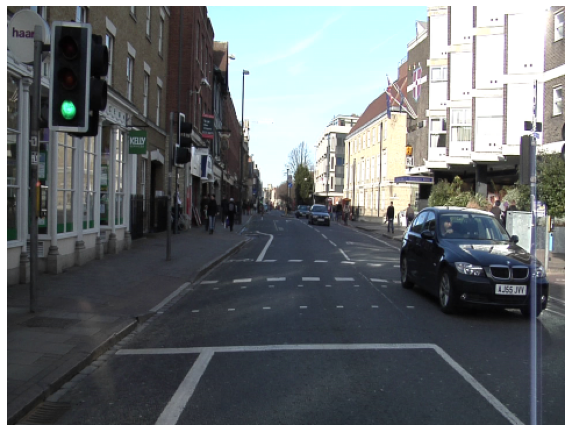

In [ ]:
# загружаем изображение
data = plt.imread(file_list1[5])
plt.figure(1, figsize=(10,10))    

# выводим изображение
plt.axis('off')
plt.imshow(data)
plt.show()

truck 89.09794092178345
car 91.25376343727112
car 96.98038101196289
car 94.16510462760925
car 71.75518274307251


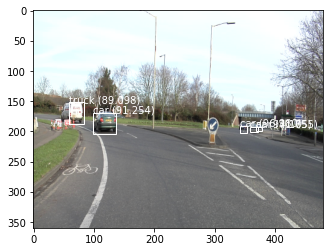

car 98.71415495872498
truck 70.7890510559082
person 75.259268283844
car 97.88491129875183
person 87.65421509742737
person 98.1534481048584
car 95.20812034606934


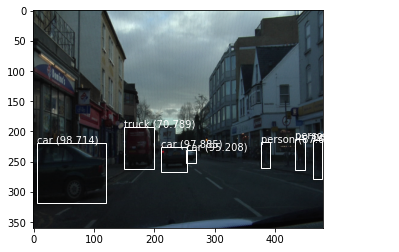

car 99.89912509918213
car 99.3863046169281
person 98.6221432685852
person 74.49942827224731
car 77.75676846504211
car 90.90501070022583
car 97.35543727874756
person 94.50457096099854


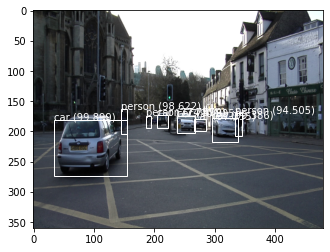

car 89.72485661506653
car 98.9988625049591


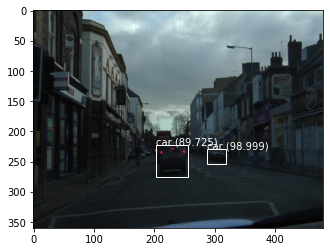

person 97.66170382499695
person 92.56001710891724
car 93.03244352340698
person 92.13707447052002
car 83.1717312335968
car 81.44904971122742
car 71.39858603477478


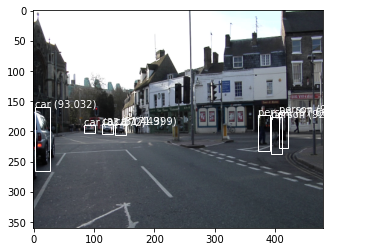

car 80.84244132041931
person 85.38354635238647
bicycle 78.35367321968079
car 74.3852436542511
car 92.05536246299744
car 85.59308648109436
car 74.31202530860901
person 93.78034472465515


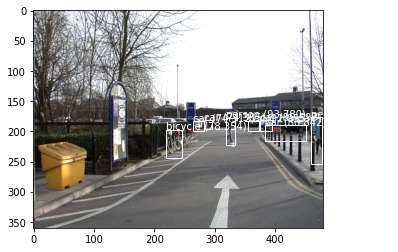

car 91.81566834449768
car 97.100830078125
car 96.90327644348145
person 85.86230874061584
person 74.1369366645813


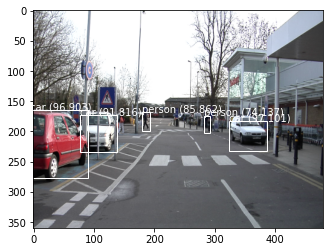

car 98.30824732780457
car 97.80257940292358
car 96.16585373878479
car 89.19706344604492
car 96.82004451751709


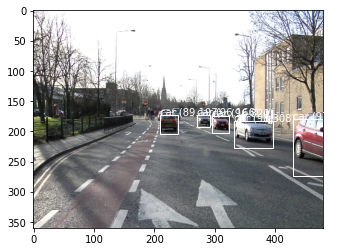

bus 92.85303950309753
truck 84.79636311531067
person 94.72818970680237
car 95.12794613838196
car 96.47850394248962
person 85.51320433616638
car 98.93379807472229


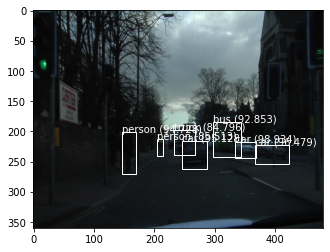

car 86.96121573448181
person 95.60410976409912


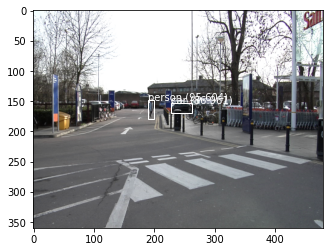

In [ ]:
object_detection(model, file_list1[10:20], 0.7, labels)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1l9jgkXm-RcvY3SE94cZiP_PYxegAoPDa?usp=sharing)
2. Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1xJnAZG5CY1sZftGGG5Qq5Ze-ZveYHcRH?usp=sharing)
